# Getting Data:  Working with APIs, TEXT analytics & Census

- **Natural language processing via Philly's 311 API**
    - Word frequencies
    - Sentiment analysis

In [5]:
import geopandas as gpd
import holoviews as hv
import hvplot.pandas
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import requests
# Show all columns
pd.options.display.max_columns = 999

# Natural Language Processing and the 311 Request API

We pull data using the API for the Philly 311 system, available at: [https://iframe.publicstuff.com/#?client_id=242](https://iframe.publicstuff.com/#?client_id=242)

![](imgs/philly-311.png)


Let's take another look at the address where the site is pulling its data from:

`https://vc0.publicstuff.com/api/2.0/requests_list?client_id=242&device=iframe&limit=35&page=1`


This is just an **API request!** It's an example of a *non-public, internal* API, but we can reverse-engineer it to extract the data we want!

Break it down into it's component parts:

- **Base URL:** [https://vc0.publicstuff.com/api/2.0/requests_list](https://vc0.publicstuff.com/api/2.0/requests_list)
- **Query parameters:** client_id, device, limit, page

It looks likes "client_id" identifies data for the City of Philadelphia, which is definitely a required parameter. Otherwise, the other parameters seem optional, returning the requests on a certain device and viewing page.


Let's test it out. We'll grab 2 requests from the first page:

In [6]:
r = requests.get(
    "https://vc0.publicstuff.com/api/2.0/requests_list",
    params={"client_id": 242, "page": 1, "limit": 2},
)
json = r.json()
json

{'response': {'requests': [{'request': {'id': 16613763,
     'image_thumbnail': '',
     'title': 'Other',
     'description': '',
     'status': 'submitted',
     'address': '9956 Haldeman Ave, Philadelphia, PA 19115, USA',
     'location': '',
     'zipcode': None,
     'foreign_id': '17469497',
     'date_created': 1741639537,
     'count_comments': 0,
     'count_followers': 0,
     'count_supporters': 0,
     'lat': 40.0970337,
     'lon': -75.0228742,
     'user_follows': 0,
     'user_comments': 0,
     'user_request': 0,
     'rank': '1',
     'user': 'KENYETTA THOMAS'}},
   {'request': {'primary_attachment': {'id': 5377066,
      'extension': 'jpg',
      'content_type': 'image/jpeg',
      'url': 'https://d17aqltn7cihbm.cloudfront.net/uploads/a58453dcf3519f2e61d7eb71bdd0dddd',
      'versions': {'small': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_a58453dcf3519f2e61d7eb71bdd0dddd',
       'medium': 'https://d17aqltn7cihbm.cloudfront.net/uploads/medium_a58453dcf3519f2

Now we need to understand the structure of the response. First, access the list of requests:

In [7]:
request_list = json["response"]["requests"]

request_list

[{'request': {'id': 16613763,
   'image_thumbnail': '',
   'title': 'Other',
   'description': '',
   'status': 'submitted',
   'address': '9956 Haldeman Ave, Philadelphia, PA 19115, USA',
   'location': '',
   'zipcode': None,
   'foreign_id': '17469497',
   'date_created': 1741639537,
   'count_comments': 0,
   'count_followers': 0,
   'count_supporters': 0,
   'lat': 40.0970337,
   'lon': -75.0228742,
   'user_follows': 0,
   'user_comments': 0,
   'user_request': 0,
   'rank': '1',
   'user': 'KENYETTA THOMAS'}},
 {'request': {'primary_attachment': {'id': 5377066,
    'extension': 'jpg',
    'content_type': 'image/jpeg',
    'url': 'https://d17aqltn7cihbm.cloudfront.net/uploads/a58453dcf3519f2e61d7eb71bdd0dddd',
    'versions': {'small': 'https://d17aqltn7cihbm.cloudfront.net/uploads/small_a58453dcf3519f2e61d7eb71bdd0dddd',
     'medium': 'https://d17aqltn7cihbm.cloudfront.net/uploads/medium_a58453dcf3519f2e61d7eb71bdd0dddd',
     'large': 'https://d17aqltn7cihbm.cloudfront.net/upl

We need to extract out the "request" key of each list entry. Let's do that and create a DataFrame:

In [8]:
data = pd.DataFrame([r["request"] for r in request_list])
data.head()

,id,image_thumbnail,title,description,status,address,location,zipcode,foreign_id,date_created,count_comments,count_followers,count_supporters,lat,lon,user_follows,user_comments,user_request,rank,user,primary_attachment
0,16613763,,Other,,submitted,"9956 Haldeman Ave, Philadelphia, PA 19115, USA",,None,17469497,1741639537,0,0,0,40.097034,-75.022874,0,0,0,1,KENYETTA THOMAS,NaN
1,16613760,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Dangerous Building Complaint,Signage on the verge of falling on pedestrians,submitted,"2101 S Beechwood St, Philadelphia, PA 19145, USA",,None,17469495,1741639534,0,0,0,39.925888,-75.182168,0,0,0,1,jjjjj,"{'id': 5377066, 'extension': 'jpg', 'content_t..."


**GREAT SUCCESS!!**  But we want to build up a larger dataset...let's pull data for the first 3 pages of data. This will take a minute or two...

In [9]:
# Store the data we request
data = []

# Total number of pages
total_pages = 3

# Loop over each page
for page_num in range(1, total_pages + 1):
    # Print out the page number
    print(f"Getting data for page #{page_num}...")

    # Make the request
    r = requests.get(
        "https://vc0.publicstuff.com/api/2.0/requests_list",
        params={
            "client_id": 242,  # Unique identifier for Philadelphia
            "page": page_num,  # What page of data to pull
            "limit": 200,  # How many rows per page
        },
    )
    # Get the json
    d = r.json()

    # Add the new data to our list and save
    data = data + [r["request"] for r in d["response"]["requests"]]

# Create a dataframe
data = pd.DataFrame(data)

Getting data for page #1...
Getting data for page #2...
Getting data for page #3...


In [10]:
len(data)

600

In [12]:
data.head(10)

,id,image_thumbnail,title,description,status,address,location,zipcode,foreign_id,date_created,count_comments,count_followers,count_supporters,lat,lon,user_follows,user_comments,user_request,rank,user,primary_attachment
0,16613800,,Abandoned Automobile,No license plate. Car has been parked for more...,submitted,"1801 Poplar St, Philadelphia, PA 19130, USA",,None,17469525,1741640012,0,0,0,39.971105,-75.166067,0,0,0,1,,NaN
1,16613795,,Recycling Collection,Our house was skipped for recycling pick up,submitted,"1240 Hemlock Dr, Philadelphia, PA 19116, USA",,None,17469515,1741639828,0,0,0,40.123736,-74.998319,0,0,0,1,Erinfurlong5,NaN
2,16613763,,Other,,submitted,"9956 Haldeman Ave, Philadelphia, PA 19115, USA",,None,17469497,1741639537,0,0,0,40.097034,-75.022874,0,0,0,1,KENYETTA THOMAS,NaN
3,16613760,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Dangerous Building Complaint,Signage on the verge of falling on pedestrians,submitted,"2101 S Beechwood St, Philadelphia, PA 19145, USA",,None,17469495,1741639534,0,0,0,39.925888,-75.182168,0,0,0,1,jjjjj,"{'id': 5377066, 'extension': 'jpg', 'content_t..."
4,16613739,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Illegal Dumping,Metal debris piled on sidewalk,submitted,"850 Moyer St,Philadelphia, PA 19125","Philadelphia, Pennsylvania",19125,17469483,1741639328,0,0,0,39.973475,-75.123507,0,0,0,1,D-RUNKLE,"{'id': 5377056, 'extension': 'jpg', 'content_t..."
5,16613732,,Fire Safety Complaint,I live across the street from the small row ho...,submitted,"207 Watkins St,Philadelphia, PA 19148","Philadelphia, Pennsylvania",19148,NaN,1741639187,0,0,0,39.926467,-75.149833,0,0,0,1,annaboland,NaN
6,16613708,,Dangerous Building Complaint,This property has caught fire sometime last Ju...,submitted,"1234 W Cambria St, Philadelphia, PA 19133, USA",,None,17469466,1741638936,0,0,0,39.996532,-75.151186,0,0,0,1,,NaN
7,16613686,,Abandoned Automobile,The car has been parked on the street for abou...,submitted,"2944 Disston St, Philadelphia, PA 19149, USA",,None,17469453,1741638728,0,0,0,40.037486,-75.055685,0,0,0,1,,NaN
8,16613661,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Graffiti Removal Request,None,submitted,"3799 Walnut St,Philadelphia, PA 19104","Philadelphia, Pennsylvania",19104,17469435,1741638445,0,0,0,39.953767,-75.198408,0,0,0,1,,"{'id': 5377041, 'extension': 'jpg', 'content_t..."
9,16613656,https://d17aqltn7cihbm.cloudfront.net/uploads/...,Abandoned Automobile,Blue Honda Pilot parked in same spot. Has not ...,submitted,"2841 S Beulah St,Philadelphia, PA 19148","Philadelphia, Pennsylvania",19148,17469432,1741638403,0,0,0,39.913041,-75.160781,0,0,0,1,scssd2,"{'id': 5377040, 'extension': 'jpg', 'content_t..."


Let's focus on the "description" column. This is the narrative text that the user inputs when entering a 311 request, and it is an example of *semi-structured* data. For the rest of today, we'll focus on how to extract information from semi-structured data.

### Semi-structured data

Data that contains some elements that cannot be easily consumed by computers 

**Examples:** human-readable text, audio, images, etc


### Key challenges

- **Text mining**: analyzing blocks of text to extract the relevant pieces of information
- **Natural language processing (NLP)**: programming computers to process and analyze human languages
- **Sentiment analysis**: analyzing blocks of text to derive the attitude or emotional state of the person

NB: Twitter is one of the main API examples of semi-structured data, but since Elon Musk overhauled the API access, it's become prohibitively expensive to access (RIP 💀)

To get started, let's remove any requests where the description is missing:

In [13]:
data = data.dropna(subset=["description"])
data_final = data.loc[data["description"] != ""]

In [14]:
# Strip out spaces and convert to a list
descriptions = data_final["description"].str.strip().tolist()

descriptions[:10]

['No license plate. Car has been parked for more than 2 months',
 'Our house was skipped for recycling pick up',
 'Signage on the verge of falling on pedestrians',
 'Metal debris piled on sidewalk',
 'I live across the street from the small row home that is inhabited by squatters who have propane tanks all over the living room that I can see as I walk by when they leave their door open. They are drug users so my biggest fear is that they fall asleep or like something on fire and they call an explosion. They also are soliciting sex for drugs out of the home and I have all of this on camera footage not the propane tanks but I can try to get pictures next time The door is open. My biggest fear is I have a teenage daughter and something is going to happen that causes me or my family harm.',
 'This property has caught fire sometime last June and was sealed up.  Since then an unknown person or persons has taken off the boards and are now trying to live in this property.  Can you please put a

### Use case #1: calculating word frequencies

An example of **text mining**

#### Text mining and dealing with messy data

Some steps to clean up our text data:

1. Break strings into words
1. Remove capitalization
1. Remove stop words
1. Remove punctuation

**1. Break strings into words**

Use the `.split()` command to break a string into words by splitting on spaces.

In [15]:
example_string = "This is an Example"
example_string.split()

['This', 'is', 'an', 'Example']

In [16]:
descriptions_words = [desc.split() for desc in descriptions]

In [17]:
descriptions_words[0]

['No',
 'license',
 'plate.',
 'Car',
 'has',
 'been',
 'parked',
 'for',
 'more',
 'than',
 '2',
 'months']

This is a list of lists, e.g., the first element is a list of words. Let's *flatten* this into a list of just words:

In [18]:
descriptions_words_flat = []

for list_of_words in descriptions_words:
    for word in list_of_words:
        descriptions_words_flat.append(word)

In [19]:
descriptions_words_flat[0]

'No'

In [20]:
len(descriptions_words_flat)

11532

**2. Convert all words to lower case**

Use `.lower()` makes all words lower cased

In [21]:
descriptions_words_lower = [word.lower() for word in descriptions_words_flat]

In [22]:
descriptions_words_lower[:10]

['no',
 'license',
 'plate.',
 'car',
 'has',
 'been',
 'parked',
 'for',
 'more',
 'than']

In [23]:
len(descriptions_words_lower)

11532

**3. Remove stop words**

Common words that do not carry much significance and are often ignored in text analysis.

We can use the `nltk` package.

The "Natural Language Toolkit" https://www.nltk.org/

Import and download the stop words:

In [24]:
import nltk

nltk.download("stopwords");

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/delmelle/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Get the list of common stop words:

In [25]:
stop_words = list(set(nltk.corpus.stopwords.words("english")))
stop_words[:100]


['couldn',
 'this',
 'for',
 'if',
 "wouldn't",
 "shouldn't",
 'such',
 'a',
 "it'd",
 'does',
 'shan',
 "she'll",
 "isn't",
 'ourselves',
 'those',
 "weren't",
 "we've",
 'the',
 'isn',
 'same',
 "you've",
 'not',
 'out',
 'so',
 'i',
 "needn't",
 'did',
 'through',
 'mustn',
 'my',
 'no',
 'you',
 'themselves',
 'been',
 'nor',
 'during',
 'by',
 "should've",
 'off',
 'doing',
 'ours',
 "they'd",
 "couldn't",
 "that'll",
 'whom',
 'any',
 'own',
 'under',
 'until',
 'yourself',
 "won't",
 'her',
 "i'm",
 'as',
 "didn't",
 "mustn't",
 'were',
 'all',
 "it's",
 'who',
 "you'll",
 "they'll",
 'each',
 'while',
 'itself',
 'them',
 'can',
 'from',
 'hadn',
 'or',
 'am',
 "he's",
 'its',
 "i've",
 'needn',
 'below',
 'is',
 "aren't",
 'some',
 "they're",
 'we',
 'it',
 'only',
 'him',
 'they',
 'weren',
 'to',
 "haven't",
 'above',
 'y',
 'more',
 'before',
 'wasn',
 'having',
 't',
 'herself',
 'won',
 'in',
 "we'd",
 "it'll"]

len(stop_words)

In [26]:
descriptions_no_stop = []

for word in descriptions_words_lower:
    if word not in stop_words:
        descriptions_no_stop.append(word)

In [27]:
descriptions_no_stop = [
    word for word in descriptions_words_lower if word not in stop_words
]

In [28]:
len(descriptions_no_stop)

6976

**4. Remove punctuation**

Get the list of common punctuation:

In [29]:
import string

In [30]:
punctuation = list(string.punctuation)

In [31]:
punctuation[:5]

['!', '"', '#', '$', '%']

Remove punctuation from words:

In [32]:
descriptions_final = []

# Loop over all words
for word in descriptions_no_stop:
    # Remove any punctuation from the words
    for p in punctuation:
        word = word.replace(p, "")

    # Save it if the string is not empty
    if word != "":
        descriptions_final.append(word)

Convert to a Dataframe with one column:

In [33]:
words = pd.DataFrame({"words": descriptions_final})

In [34]:
words.head()

,words
0,license
1,plate
2,car
3,parked
4,2


**Calculate the word frequencies** 

Use a pandas groupby and sort to put in descending order:

In [35]:
N = (
    words.groupby("words", as_index=False)
    .size()
    .sort_values("size", ascending=False, ignore_index=True)
)

In [36]:
top15 = N.head(15)

top15

,words,size
0,street,136
1,trash,71
2,people,54
3,tricked,50
4,parked,47
5,block,46
6,car,45
7,please,42
8,months,40
9,property,39


**Plot the frequencies**

Use `seaborn` to plot our DataFrame of word counts...

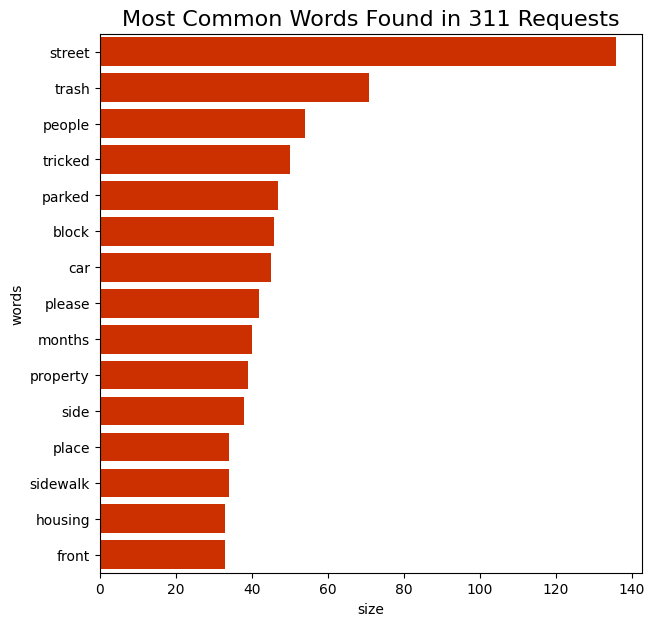

In [37]:
fig, ax = plt.subplots(figsize=(7, 7))

# Plot horizontal bar graph
sns.barplot(
    y="words",
    x="size",
    data=top15,
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Most Common Words Found in 311 Requests", fontsize=16);

**Takeaway:** Philly cares about trash! They don't call it Filthadelphia for nothing...

## Sentiment Analysis

In [38]:
# Data analysis
import geopandas as gpd
import numpy as np
import pandas as pd

# APIs
import requests

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
import holoviews as hv
import hvplot.pandas

In [39]:
N = words.groupby("words", as_index=False).size().sort_values("size", ascending=False, ignore_index=True)

**The goal**

Determine the "sentiment" of every word in the English language

*The hard way*

Train a machine learning algorithm to classify words as positive vs. negative, given an input training sample of words.

*The easy way*

Luckily, this is a **very common** task in NLP and there are several packages available that have done the hard work for you. 

They provide out-of-the-box sentiment analysis using pre-trained machine learning algorithms.

#### The `textblob` package

First, let's try out a package called `textblob`. Textblob can calculate the "polarity" of words, from negative -1 to postive +1. 

It's algorithm is not particularly sophisticated (as we will see). It was trained on IMDB movie reviews and uses a dictionary mapping of adjectives to sentiment values. So, it knows about a set of adjectives and an approximate *polarity* for those words. 

Let's try it out on the words from the 311 requests

In [40]:
import textblob

First, copy our "words" dataframe and drop any duplicate words. We'll try to calculate the sentiment for each word.

In [41]:
sentiment = words.copy().drop_duplicates(subset=['words'])

In [42]:
sentiment.head()

,words
0,license
1,plate
2,car
3,parked
4,2


Now, create our "text blob" objects:

In [43]:
blobs = [textblob.TextBlob(word) for word in sentiment['words']]

Now use the ".polarity" attribute to calculate the sentiment:

In [44]:
sentiment["polarity"] = [blob.polarity for blob in blobs]

In [45]:
sentiment.head(10)

,words,polarity
0,license,0.0
1,plate,0.0
2,car,0.0
3,parked,0.0
4,2,0.0
5,months,0.0
6,house,0.0
7,skipped,0.0
8,recycling,0.0
9,pick,0.0


Most of these words are zero!

In [46]:
(sentiment['polarity'] == 0).sum()

1713

In [47]:
len(sentiment)

1862

Why did this happen?

Because the universe of words that TextBlob knows about is pretty small! Mostly confined to common adjectives/adverbs that appeared in its IMDB review dataset.

Let's take a look at the words with nonzero polarity:

In [48]:
sentiment_nonzero = sentiment.query("polarity != 0")

What are the top 15 most positive words?

In [49]:
sentiment_nonzero.sort_values("polarity", ascending=False, ignore_index=True).head(15)

,words,polarity
0,best,1.0
1,fly,0.8
2,good,0.7
3,hazardous,0.6
4,lmao,0.6
5,safely,0.5
6,safe,0.5
7,sure,0.5
8,mostly,0.5
9,respectful,0.5


What are the top 15 most negative words?

In [50]:
sentiment_nonzero.sort_values("polarity", ascending=True, ignore_index=True).head(15)

,words,polarity
0,worst,-1.000000
1,terrible,-1.000000
2,nasty,-1.000000
3,disgusting,-1.000000
4,base,-0.800000
5,sick,-0.714286
6,bad,-0.700000
7,impossible,-0.666667
8,dangerously,-0.600000
9,cold,-0.600000


What about a histogram of the sentiment?

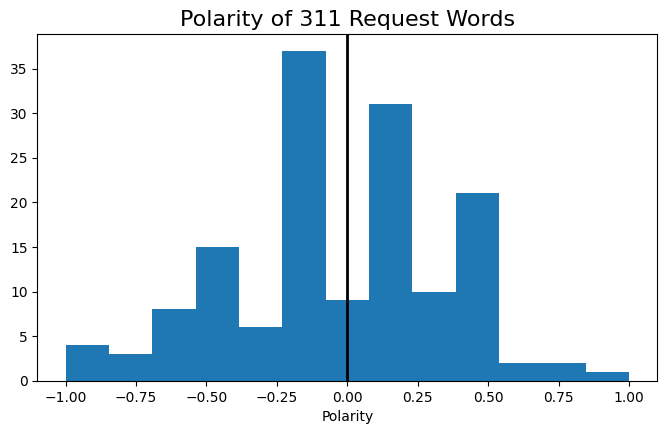

In [51]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4.5))

# histogram
ax.hist(sentiment_nonzero["polarity"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Request Words", fontsize=16);

Hmm...this is surprising! There are many more positive words than I would have guessed!

**What could be going on?**


Most of the 311 requests are in fact *very* negative. They are mostly complaints, after all.

In the previous analysis, TextBlob only knows the sentiment for a *small* subset of the words. This is makes it difficult to produce a comprehensive sentiment for the entirety of the text for each 311 request. This is difficult because context really matters! Let's see an example:

As you can see in the below example, the negation is not picked up by the algorithm: 

In [52]:
textblob.TextBlob("Philly 311 is the best").polarity

1.0

In [53]:
textblob.TextBlob("Philly 311 is NOT the best").polarity

1.0

Both are marked as positive! (because of the word "best")

Can we do better? YES!

#### The `transformers` package

The Hugging Face `transformers` package ([documentation](https://huggingface.co/docs/transformers/index)) provides access to state-of-the-art, pre-trained machine learning algorithms for natural language processing. 

It provides access to more sophisticated machine learning models that are capable of measuring the sentiment of a piece of text using the full context of the words.



We can use the transformers `pipeline()` function to load and run our pre-trained models

In [54]:
from transformers import pipeline

#### Positive/Negative sentiment analysis

We'll start with a version of the [DistilBERT](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) model that has been fine-tuned on the [Stanford Sentiment Treebank](https://huggingface.co/datasets/sst2) dataset.

For an input series of text, this model will predict the POSITIVE / NEGATIVE labels with associated confidence scores. It will tell us how likely it thinks the text is positive or negative.

::: {.callout-tip}
For more info on sentiment analysis with the `transformers` package, check out this [tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification).
:::

In [55]:
# The name of the model we are using
model = "distilbert-base-uncased-finetuned-sst-2-english"

# Initialize our sentiment analyzer
sentiment_classifier = pipeline(
    task="sentiment-analysis",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

/Users/delmelle/miniforge3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Now, let's pass our original list of request descriptions to the classifier. 

::: {.callout-note}
We don't need to do any text pre-processing here! We'll just pass in the raw text, so no need to remove stop words, punctuation, etc.
:::


We're now running a much more sophisticated model, so it will take more time to execute! This will likely take 2-3 minutes to run...

In [56]:
%%time

scores = sentiment_classifier(descriptions)

CPU times: user 1min 10s, sys: 1.72 s, total: 1min 12s
Wall time: 10.3 s


What does the response structure look like?

For each description, we get a dictionary containing the label (`POSITIVE` or `NEGATIVE`) and the associated score:

In [57]:
scores[:10]

[[{'label': 'NEGATIVE', 'score': 0.9968447685241699},
  {'label': 'POSITIVE', 'score': 0.003155315760523081}],
 [{'label': 'NEGATIVE', 'score': 0.9995304346084595},
  {'label': 'POSITIVE', 'score': 0.0004696148680523038}],
 [{'label': 'NEGATIVE', 'score': 0.9974465370178223},
  {'label': 'POSITIVE', 'score': 0.0025534331798553467}],
 [{'label': 'NEGATIVE', 'score': 0.9981185793876648},
  {'label': 'POSITIVE', 'score': 0.001881344011053443}],
 [{'label': 'NEGATIVE', 'score': 0.9982715845108032},
  {'label': 'POSITIVE', 'score': 0.0017284060595557094}],
 [{'label': 'NEGATIVE', 'score': 0.9951809644699097},
  {'label': 'POSITIVE', 'score': 0.004819096997380257}],
 [{'label': 'NEGATIVE', 'score': 0.9953938722610474},
  {'label': 'POSITIVE', 'score': 0.0046060942113399506}],
 [{'label': 'NEGATIVE', 'score': 0.9963836669921875},
  {'label': 'POSITIVE', 'score': 0.0036162862088531256}],
 [{'label': 'NEGATIVE', 'score': 0.6846440434455872},
  {'label': 'POSITIVE', 'score': 0.31535595655441284}

Let's unpack this to a more useful format:

In [58]:
yes_no = pd.DataFrame([{d["label"]: d["score"] for d in dd} for dd in scores]).assign(
    text=descriptions
)

In [64]:
yes_no.head()

0    No license plate. Car has been parked for more...
1          Our house was skipped for recycling pick up
2       Signage on the verge of falling on pedestrians
3                       Metal debris piled on sidewalk
4    I live across the street from the small row ho...
Name: text, dtype: object

**Note:** The scores summed across both labels will sum up to 1. 


**Total sentiment calculation**:
We can calculate the overall score by multiplying the value for each label, e.g., (POSITIVE = +1 and NEGATIVE = -1) by the confidence score for each label. This gives an overall sentiment estimate for each piece of text:

In [65]:
yes_no["sentiment"] = (yes_no["POSITIVE"] * +1) + (yes_no["NEGATIVE"] * -1)

In [66]:
yes_no.head()

,NEGATIVE,POSITIVE,text,sentiment
0,0.996845,0.003155,No license plate. Car has been parked for more...,-0.993689
1,0.999530,0.000470,Our house was skipped for recycling pick up,-0.999061
2,0.997447,0.002553,Signage on the verge of falling on pedestrians,-0.994893
3,0.998119,0.001881,Metal debris piled on sidewalk,-0.996237
4,0.998272,0.001728,I live across the street from the small row ho...,-0.996543


**Question:** Are most of the reviews positive or negative?


Let's take a look at the mean and median:

In [67]:
yes_no['sentiment'].mean()

-0.8349780015063472

In [68]:
yes_no['sentiment'].median()

-0.9954100323375314

Ah! By far, most of these are negative!

Philadelphians using the 311 system appear to be *very* upset.

Let's take a look at the overall histogram of sentiment too:

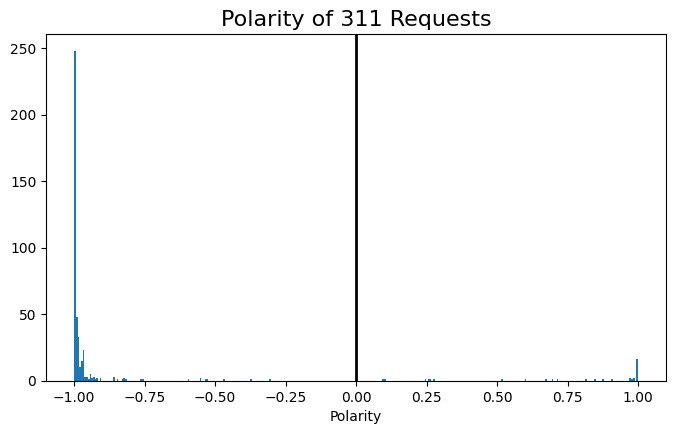

In [69]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(8, 4.5))

# Histogram
ax.hist(yes_no['sentiment'], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Requests", fontsize=16);

Whoa! Very negative sentiment!

**This makes much more sense than our earlier results with the Textblob package.**

Let's look at the 10 requests with the lowest sentiment scores:

In [70]:
yes_no.sort_values("sentiment", ascending=True).head(10)

,NEGATIVE,POSITIVE,text,sentiment
339,0.999801,0.000199,Looks like a sink hole,-0.999602
26,0.999796,0.000204,The car has been sitting in front of my house ...,-0.999593
191,0.999795,0.000205,A large service ditch in the left driving lane...,-0.999590
425,0.999792,0.000208,Large sink hole at the stop sign,-0.999585
305,0.999790,0.000210,Abandoned by local park over 6mo. All tires flat,-0.999581
78,0.999778,0.000222,Pothole is getting worse .,-0.999556
226,0.999775,0.000225,gray Ford Fusion appears disabled parked in th...,-0.999550
277,0.999774,0.000226,There are three inlets on the 2100 block of E ...,-0.999548
217,0.999767,0.000233,The oversized large indented hole is in front ...,-0.999535
219,0.999766,0.000234,Random assortment of dumped items. Started wit...,-0.999532


And the 10 requests with the highest sentiment:

In [173]:
yes_no.sort_values("sentiment", ascending=False).head(10)

,NEGATIVE,POSITIVE,text,sentiment
276,0.000185,0.999815,Murphy Recreation Center rear wall. Thank you.,0.999631
373,0.000289,0.999711,Graffiti on sign. Please and thank you!,0.999422
153,0.000361,0.999639,Graffiti and stickers on parking sign pole. Pl...,0.999278
246,0.000832,0.999168,Again!!!,0.998336
214,0.004345,0.995655,street light out,0.991310
141,0.005592,0.994408,School district of Philadelphia,0.988816
44,0.005714,0.994286,Unleveled sidewalk where water collects/pools ...,0.988572
181,0.007140,0.992860,Please help and correct for all my neighbors s...,0.985720
449,0.010813,0.989187,Please pick up or remove this illegal dumping ...,0.978373
204,0.011188,0.988812,Capri restaurant building a new structure,0.977624


**Takeaway**

The model is still clearly focusing on some crucial words (please, thank you = "positive") but overall, doing a much, much better job overall of understanding the full context of the text. 

#### Emotion sentiment analysis

The `transformers` package also includes pre-trained models that can predict *emotion* labels. 

As an example, let's try out [this version](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) of the DistilBERT model that can predict the following labels for a string of text: anger, fear, sadness, joy, love, and surprise.

In [72]:
# The model
model = "bhadresh-savani/distilbert-base-uncased-emotion"

# Initialize our sentiment analyzer
emotion_classifier = pipeline(
    task="text-classification",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

/Users/delmelle/miniforge3/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Classify the 311 descriptions using our emotions model. Once again, this will likely take 2-3 minutes to run:

In [73]:
%%time 

emotion_scores = emotion_classifier(descriptions)

CPU times: user 1min 8s, sys: 1.22 s, total: 1min 9s
Wall time: 8.75 s


In [74]:
emotion_scores[0]

[{'label': 'fear', 'score': 0.7331622242927551},
 {'label': 'anger', 'score': 0.23640018701553345},
 {'label': 'sadness', 'score': 0.013925026170909405},
 {'label': 'joy', 'score': 0.013106637634336948},
 {'label': 'surprise', 'score': 0.0023219578433781862},
 {'label': 'love', 'score': 0.0010839784517884254}]

Unpack the label/score combos into a DataFrame:

In [75]:
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]
).assign(text=descriptions)

In [76]:
emotion.head()

,fear,anger,sadness,joy,surprise,love,text
0,0.733162,0.236400,0.013925,0.013107,0.002322,0.001084,No license plate. Car has been parked for more than 2 months
1,0.026432,0.805123,0.145952,0.019186,0.002276,0.001031,Our house was skipped for recycling pick up
2,0.982022,0.011605,0.003893,0.001234,0.001005,0.000241,Signage on the verge of falling on pedestrians
3,0.925558,0.047537,0.017832,0.003040,0.005226,0.000807,Metal debris piled on sidewalk
4,0.991878,0.004407,0.002045,0.000935,0.000492,0.000243,I live across the street from the small row home that is inhabited by squatters who have propane tanks all over the living room that I can see as I walk by when they leave their door open. They are drug users so my biggest fear is that they fall asleep or like something on fire and they call an explosion. They also are soliciting sex for drugs out of the home and I have all of this on camera footage not the propane tanks but I can try to get pictures next time The door is open. My biggest fear is I have a teenage daughter and something is going to happen that causes me or my family harm.


Now, let's calculate the predicted label for each text. This is the label with the highest score for each text.

In [77]:
emotion_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]

Use the `idxmax()` function to find the column with the maximum value for each row:

In [78]:
emotion[emotion_labels].idxmax(axis=1)

0         fear
1        anger
2         fear
3         fear
4         fear
5         fear
6         fear
7         fear
8        anger
9        anger
10     sadness
11       anger
12        fear
13        fear
14       anger
15         joy
16     sadness
17       anger
18     sadness
19        fear
20       anger
21       anger
22        fear
23       anger
24       anger
25        fear
26       anger
27        fear
28        fear
29        fear
30        fear
31       anger
32       anger
33       anger
34       anger
35       anger
36         joy
37     sadness
38        fear
39         joy
40         joy
41       anger
42        fear
43         joy
44       anger
45        fear
46       anger
47       anger
48        fear
49     sadness
50     sadness
51        fear
52        fear
53        fear
54        fear
55       anger
56        fear
57       anger
58         joy
59       anger
60       anger
61         joy
62       anger
63        fear
64       anger
65         joy
66     sad

In [79]:
emotion['prediction'] = emotion[emotion_labels].idxmax(axis=1)

In [80]:
emotion.head()

,fear,anger,sadness,joy,surprise,love,text,prediction
0,0.733162,0.236400,0.013925,0.013107,0.002322,0.001084,No license plate. Car has been parked for more than 2 months,fear
1,0.026432,0.805123,0.145952,0.019186,0.002276,0.001031,Our house was skipped for recycling pick up,anger
2,0.982022,0.011605,0.003893,0.001234,0.001005,0.000241,Signage on the verge of falling on pedestrians,fear
3,0.925558,0.047537,0.017832,0.003040,0.005226,0.000807,Metal debris piled on sidewalk,fear
4,0.991878,0.004407,0.002045,0.000935,0.000492,0.000243,I live across the street from the small row home that is inhabited by squatters who have propane tanks all over the living room that I can see as I walk by when they leave their door open. They are drug users so my biggest fear is that they fall asleep or like something on fire and they call an explosion. They also are soliciting sex for drugs out of the home and I have all of this on camera footage not the propane tanks but I can try to get pictures next time The door is open. My biggest fear is I have a teenage daughter and something is going to happen that causes me or my family harm.,fear


What's the breakdown across the predicted labels?

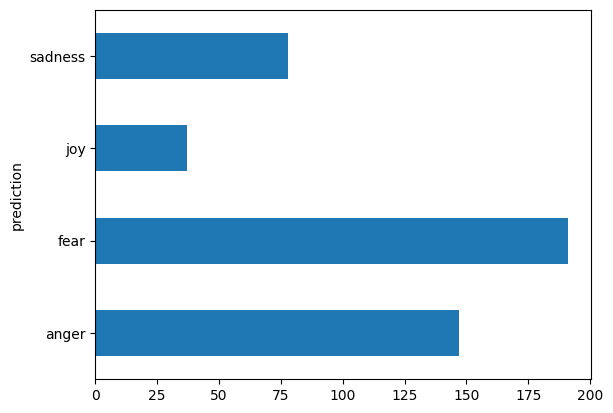

In [81]:
emotion.groupby("prediction").size().plot(kind='barh');

**Takeaway:**  Most descriptions are classified as "fear" or "anger"

How about visualizing the full distribution of scores across all emotions?

Let's get a tidy version for analysis:

In [82]:
emotion_tidy = emotion.melt(
    id_vars=["text"], value_vars=emotion_labels, var_name="emotion", value_name="score"
)

In [83]:
emotion_tidy.head()

,text,emotion,score
0,No license plate. Car has been parked for more than 2 months,anger,0.236400
1,Our house was skipped for recycling pick up,anger,0.805123
2,Signage on the verge of falling on pedestrians,anger,0.011605
3,Metal debris piled on sidewalk,anger,0.047537
4,I live across the street from the small row home that is inhabited by squatters who have propane tanks all over the living room that I can see as I walk by when they leave their door open. They are drug users so my biggest fear is that they fall asleep or like something on fire and they call an explosion. They also are soliciting sex for drugs out of the home and I have all of this on camera footage not the propane tanks but I can try to get pictures next time The door is open. My biggest fear is I have a teenage daughter and something is going to happen that causes me or my family harm.,anger,0.004407


Make a box plot of the distribution across all emotions:

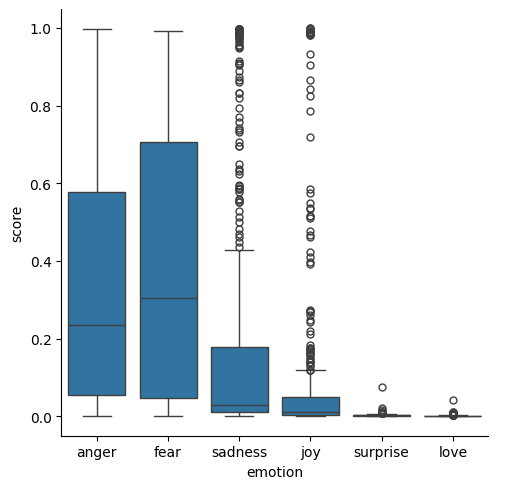

In [84]:
sns.catplot(data=emotion_tidy, x="emotion", y="score", kind="box");

**Takeaway:**

Fear and anger! For emotions other than anger/fear, confidence scores are concentrated near zero, indicating that the text likely does not contain those emotions.

Let's do a deeper dive on some of the emotions:

**Anger**

In [85]:
angry_requests = emotion.query("anger > 0.8").sort_values("anger", ascending=False)

In [86]:
len(angry_requests)

58

In [87]:
angry_requests.head(20)

,fear,anger,sadness,joy,surprise,love,text,prediction
134,0.000784,0.998015,0.000587,0.000264,0.000162,0.000188,Trash collection didn't pick up trash that's on the curb. Picked up all neighbors trash but never bothered to look on curb at my residence.,anger
346,0.001738,0.996879,0.000417,0.000441,0.000193,0.000333,Very Dangerous and has been there for a long while.,anger
284,0.001728,0.996067,0.000893,0.000678,0.000261,0.000374,This is disgusting. It needs to be clean. It is deadly and can kill a kid,anger
421,0.003270,0.995120,0.000603,0.000580,0.000172,0.000254,"Hi! \r\n\r\nThis person continues to park here for most of the day and night. They think it's their personal parking spot. It's extremely dangerous as you can't see as you pull out of Ogden and people can't see you coming up 16th. This has been a problem for over a year now and it's not enforced. This person is just the latest taking advantage of that. I've seen many accidents and have been part of one myself. I've been trying to report this for months, but I've never seen a ticket on their car. And I see it daily",anger
334,0.003793,0.994834,0.000641,0.000316,0.000162,0.000254,"dangerous motorcycle on sidewalk, have ìt removed. Dangerous for children and pedestrian.",anger
94,0.002170,0.994699,0.002430,0.000417,0.000125,0.000159,"Empty lot for years - tons of dangerous metal, rocks, and trash. Tons of trash - property owners have not taken care of lot.",anger
24,0.004276,0.994185,0.000472,0.000551,0.000202,0.000315,Can you place speed cushions on Ellicott road? Cars are speeding thru the neighborhood. There are kids playing everywhere in the neighborhood. Very dangerous for children,anger
381,0.004392,0.993281,0.001329,0.000635,0.000159,0.000204,"There are two breaks, bracketing this address, though not too closely. Maybe emerging from the property, but the southern break is definitely damaging the sidewalk integrity in a dangerous way, like a forming sinkhole. I tried calling the Water Emergency number but it hung up on me repeatedly.",anger
84,0.005923,0.992241,0.000838,0.000620,0.000180,0.000198,Traffic light not working at this extremely dangerous intersection,anger
166,0.008769,0.989099,0.000808,0.000853,0.000215,0.000258,The illuminating light at the traffic stop (not the traffic light) is not working making it dangerous.,anger


**Fear**

And the most fearful:

In [88]:
fearful_requests = emotion.query("fear > 0.8").sort_values("fear", ascending=False)

In [89]:
len(fearful_requests)

72

In [90]:
fearful_requests.head(20)

,fear,anger,sadness,joy,surprise,love,text,prediction
4,0.991878,0.004407,0.002045,0.000935,0.000492,0.000243,I live across the street from the small row home that is inhabited by squatters who have propane tanks all over the living room that I can see as I walk by when they leave their door open. They are drug users so my biggest fear is that they fall asleep or like something on fire and they call an explosion. They also are soliciting sex for drugs out of the home and I have all of this on camera footage not the propane tanks but I can try to get pictures next time The door is open. My biggest fear is I have a teenage daughter and something is going to happen that causes me or my family harm.,fear
290,0.989706,0.005689,0.001554,0.002028,0.000826,0.000196,"RE: A TRIPPING HAZARD!\r\n\r\nIN THE FRONT OF THE ""SOUTH-SIDE ENTRANCE"" OF THE ""CITY HALL BUILDING,"" THIS DEVICE IS ONE OF THE ""TWO DEVICES"" THAT NEEDS TO BE EXAMINED AND STABILIZED THROUGH THE INCLUSION OF THE ""NEEDED SCREWS!""\r\n\r\nIMPORTANT, THE TWO DEVICES (TWINS OR THE SAME TWO DEVICES) ARE, VERILY, TRIPPING HAZARDS TO THE MANY, UNAWARE PEDESTRIANS WHO ENTERS AND EXITS THE ""SOUTH-SIDE ENTRANCE"" OF THE CITY HALL BUILDING!\r\n\r\nNEVERTHELESS, HERE IS OF THE LOCATION OF ""TWO UNSTABLE DEVICES"" THAT ACTS AS DANGEROUS TRIPPING HAZARDS TO THE UNAWARE PEDESTRIANS:\r\n\r\nTHE INTERSECTION OF THE ""BROAD STREET"" AND ""SOUTH PENN SQUARE"" AND AT THE ""SOUTH-SIDE ENTRANCE"" OF THE ""CITY HALL BUILDING!""\r\n\r\nTHANK YOU!",fear
2,0.982022,0.011605,0.003893,0.001234,0.001005,0.000241,Signage on the verge of falling on pedestrians,fear
222,0.977184,0.005688,0.011581,0.003288,0.001900,0.000358,vehicle appears disabled park into the traffic lane,fear
139,0.975525,0.016687,0.003994,0.001829,0.001695,0.000270,this is blocking half for the roadway. it is on the 2700-2800 S 15th side of the address. it seems to be but automotive debris,fear
51,0.970517,0.008657,0.017859,0.001462,0.001081,0.000423,stickers are from 8 24 and the car is leaking fluids,fear
99,0.968525,0.003400,0.021638,0.003013,0.003016,0.000408,WRECKED DAMAGE Mercedes Benz CLA 250 was left by an unmarked TOW truck at 418 AM 7 MARCH 2025,fear
336,0.964785,0.007167,0.024020,0.002058,0.001604,0.000367,Older Model Cadillac Sedan broken down. All windows are out. Currently covered up with trash bags. Vehicle has body damage as well. Been parked here for about 5 days now. Appears unoperable.,fear
194,0.963108,0.027566,0.003542,0.003374,0.001815,0.000594,The sinkhole is about ten feet long and six inches deep and is forming in the parking lane in front of the residence.,fear
54,0.962627,0.026125,0.004515,0.005033,0.001267,0.000433,White Mercedes Benz. Blocking handicapped ramp on sidewalk. Trunk appears open. Has been there for 5 days.,fear


**Takeaway:**

Overall, the algorithm is doing a pretty good job picking up the emotion and sentiment in the requests. 

One potential use case for a model like this: *prioritizing responses*. For example:

- You might want to respond more quickly to those that are classified as the most fearful, given that those situations might be the most dangerous. 
- Or, requests that are classified as the angriest might warrant a closer follow-up from a city representative, since many of these requests are likely repeated requests from frustrated residents.

But, once again, we see the limitations of sentiment analysis as text with words like "thank you" and "please" get classified as positive ("joy"):

In [91]:
joyful_requests = emotion.query("joy > 0.8").sort_values("joy", ascending=False)

Not that many requests!

In [92]:
len(joyful_requests)

20

In [93]:
joyful_requests.head(20)

,fear,anger,sadness,joy,surprise,love,text,prediction
352,0.000289,0.000148,0.000248,0.998845,0.000165,0.000305,Street light been out for the 2 pass month now making it a concern for pedestrians walking at night to feel safe.,joy
449,0.000316,0.000174,0.000263,0.998784,0.000181,0.000282,The city needs to have the mayor coMe to see 7 trucks in this lot and nowhere to park people hide with the missing children people should feel safe. Tax Money and police need to be present.start ticketing but after all the crime theY need to be moved.Water department can't finish because of the blocking and activity,joy
276,0.000094,0.000178,0.000297,0.997809,0.000137,0.001485,"The street light turns on and off all night, and the strength of the light dims and brightens as well. Would appreciate a fix, thank you!",joy
70,0.000986,0.001315,0.000836,0.995737,0.000241,0.000884,"Stop signs are needed at this intersection. To ESTABLISH THE RIGHT OF WAY. At the current time there is nothing to help drivers and pedestrians at an intersection decide who has the right-of-way. ""Safety Issue ""A stop sign is a traffic sign designed to notify drivers that they must come to a complete stop and make sure the intersection is safely clear of vehicles and pedestrians before continuing past the sign. There is a church and school at this location please help. thank you.",joy
250,0.000496,0.002613,0.001341,0.989387,0.000471,0.005691,Graffiti on pole. Please and thank you!,joy
252,0.000496,0.002613,0.001341,0.989387,0.000471,0.005691,Graffiti on pole. Please and thank you!,joy
246,0.000496,0.002613,0.001341,0.989387,0.000471,0.005691,Graffiti on pole. Please and thank you!,joy
253,0.000729,0.003696,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!,joy
241,0.000729,0.003696,0.001794,0.988631,0.000529,0.004622,Graffiti on sign. Please and thank you!,joy
404,0.000380,0.002572,0.001490,0.986838,0.000328,0.008391,There's a tag in black spray paint on the E. Juniata Street (2600 block) side of 4204 E. Thompson ... It's by the NE corner of Almond and Juniata.\r\nThanks.,joy


*Sentiment analysis* -- a helpful, but imperfect analysis tool!

## That's it!